In [149]:
import pandas as pd
import os 
from src.files import XMLFile, FASTAFile, GBFFFile, InterProScanFile
from src.tools import MMseqs
from src import get_genome_id
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi

%load_ext autoreload 
%autoreload 2

# TODO: Find out if the pseudogene length in NCBI reference reads through the frameshift. I think this might only be true for PGAP-annotated?
# TODO: Look into the Prodigal-extended pseudogenes. 
# TODO: Make sure the label assignments for real, spurious, suspect_match, etc. are mutually-exclusive.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
ref_df = load_ref(genome_ids=genome_metadata_df.index)

In [151]:
ref_df['n_truncated'] = is_n_truncated(ref_df) 
ref_df['c_truncated'] = is_c_truncated(ref_df)  
ref_df['n_extended'] = is_n_extended(ref_df)
ref_df['c_extended'] = is_c_extended(ref_df)

ref_df['suspect_match'] = is_suspect_match(ref_df)
ref_df['suspect_conflict'] = is_suspect_conflict(ref_df)
ref_df['intergenic'] = is_intergenic(ref_df)
ref_df['real'] = is_real(ref_df)
ref_df['spurious'] = is_spurious(ref_df)

In [152]:
def table_1(genome_metadata_df:pd.DataFrame, path:str='../figures/errors-table_1.png'):
    table_df = pd.DataFrame(index=genome_metadata_df.phylum_name.unique())
    table_df['num. species'] = genome_metadata_df.groupby('phylum_name').apply(len, include_groups=False)
    table_df['mean GC percent'] = genome_metadata_df.groupby('phylum_name').assembly_stats_gc_percent.mean()
    table_df['mean GC percent'] = table_df['mean GC percent'].map('{:.2f}%'.format)

    dfi.export(table_df, path)
    return table_df

table_1(genome_metadata_df)

19008 bytes written to file /tmp/tmpg34sww6x/temp.png


,num. species,mean GC percent
Campylobacterota,197,34.95%
Planctomycetota,135,57.73%
Deinococcota,129,66.65%


/home/prichter/Documents/tripy/notebooks/utils.py:50: UserWarning: get_lengths: Not all gene lengths are divisible by three.
  return lengths // 3
/home/prichter/Documents/tripy/notebooks/utils.py:50: UserWarning: get_lengths: Not all gene lengths are divisible by three.
  return lengths // 3


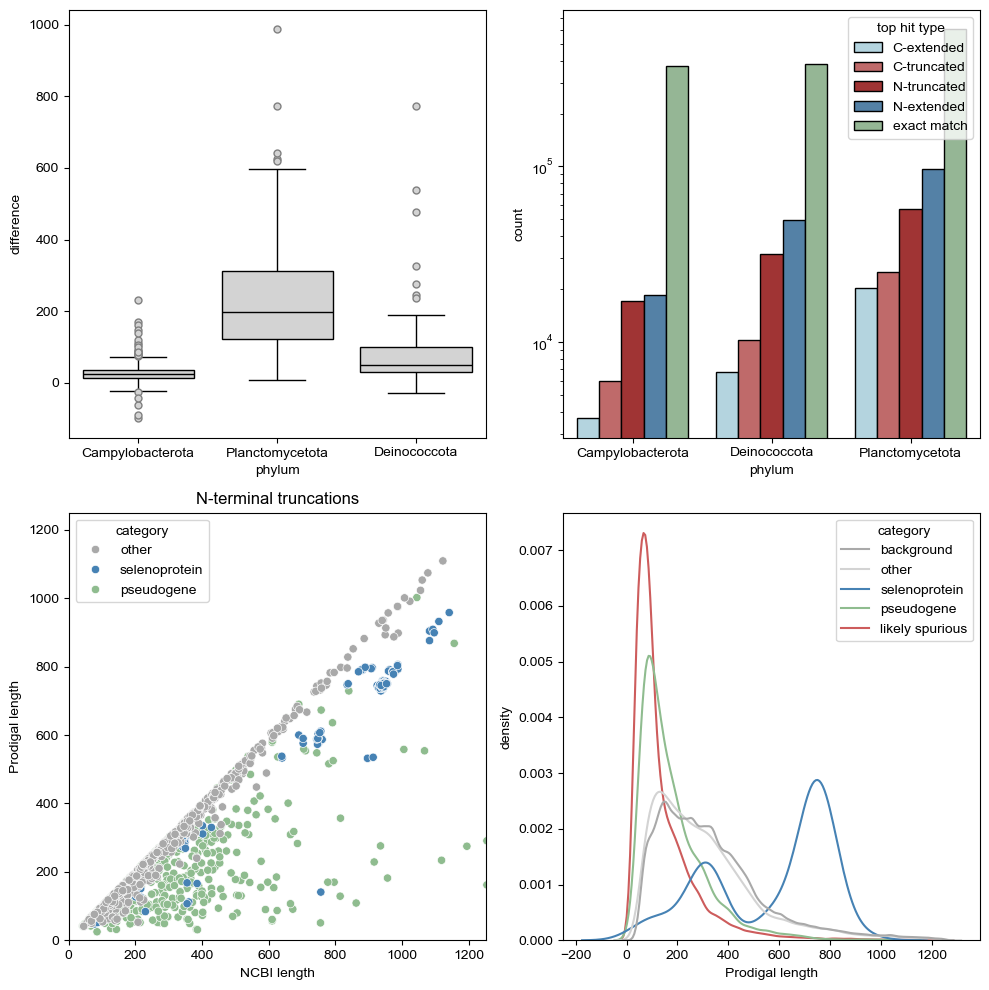

In [153]:
def figure_1(genome_metadata_df:pd.DataFrame, ref_df:pd.DataFrame, path:str='../figures/errors-figure_1.png'):

    fig = plt.figure(figsize=(10, 10), layout='tight')
    grid = GridSpec(nrows=2, ncols=2, figure=fig)
    ax_a, ax_b, ax_c, ax_d = fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[1, 1])

    ax_a_df = pd.DataFrame(index=genome_metadata_df.index)
    ax_a_df['phylum'] = pd.Categorical(genome_metadata_df.phylum_name, ['Campylobacterota', 'Planctomycetota', 'Deinococcota'], ordered=True)
    ax_a_df['gc_percent'] = genome_metadata_df.assembly_stats_gc_percent
    ax_a_df['n_genes_prodigal'] = [len(FASTAFile(f'../data/proteins/prodigal/{genome_id}_protein.faa')) for genome_id in ax_a_df.index]
    ax_a_df['n_genes_ncbi'] = genome_metadata_df['annotation_count_gene_protein-coding']
    ax_a_df['difference'] = ax_a_df.n_genes_prodigal - ax_a_df.n_genes_ncbi
    ax_a_df = ax_a_df.sort_values('phylum')
    flierprops = {'markersize':5, 'markeredgecolor':'gray', 'markerfacecolor':'lightgray'}
    sns.boxplot(data=ax_a_df, x='phylum', y='difference', ax=ax_a, color='lightgray', linecolor='black', fill=True, linewidth=1, flierprops=flierprops)

    ax_b_df = pd.DataFrame(index=ref_df.index)
    ax_b_df['genome_id'] = ref_df.genome_id 
    ax_b_df['phylum'] = ax_b_df.merge(genome_metadata_df[['phylum_name']], left_on='genome_id', right_index=True).phylum_name
    ax_b_df[['N-truncated', 'C-truncated', 'N-extended', 'C-extended', 'exact match']] = ref_df[['n_truncated', 'c_truncated', 'n_extended', 'c_extended', 'top_hit_match']]
    ax_b_df = ax_b_df.drop(columns=['genome_id']).groupby('phylum').sum().reset_index()
    ax_b_df = ax_b_df.melt(id_vars=['phylum'], var_name='top hit type', value_name='count')
    hue_order = ['C-extended', 'C-truncated', 'N-truncated', 'N-extended', 'exact match']
    colors = ['lightblue', 'indianred', 'firebrick', 'steelblue', 'darkseagreen']
    ax_b = sns.barplot(data=ax_b_df, ax=ax_b, x='phylum', y='count', hue='top hit type', edgecolor='black', palette=colors, hue_order=hue_order)    
    ax_b.set_yscale('log')

    ax_c_df = pd.DataFrame(index=ref_df.index)
    ax_c_df['NCBI length'] = get_lengths(ref_df, top_hit=True)
    ax_c_df['Prodigal length'] = get_lengths(ref_df, top_hit=False)
    conditions = [ref_df.top_hit_pseudo, ref_df.top_hit_seq.str.contains('U')]
    choices = ['pseudogene', 'selenoprotein']
    ax_c_df['category'] = np.select(conditions, choices, default='other')
    ax_c_df = ax_c_df[(ref_df.top_hit_valid) & (ref_df.n_truncated) & (~ref_df.c_extended)].copy() # Only include valid hits and N-terminal truncations. 
    colors = ['darkgray', 'steelblue', 'darkseagreen']
    hue_order = ['other', 'selenoprotein', 'pseudogene']
    n_per_category = {'pseudogene':500, 'selenoprotein':(ax_c_df.category == 'selenoprotein').sum(), 'other':500}
    sns.scatterplot(data=pd.concat([ax_c_df[ax_c_df.category == category].sample(n) for category, n in n_per_category.items()]), x='NCBI length', y='Prodigal length', hue='category', palette=colors, ax=ax_c, hue_order=hue_order)
    ax_c.set_xlim(xmin=0, xmax=1250)
    ax_c.set_ylim(ymin=0, ymax=1250)
    ax_c.set_title('N-terminal truncations')

    ax_d_df = ref_df[ref_df.spurious].copy().assign(category='likely spurious') # Seems like a reasonable guess for which sequences might be spurious.
    ax_d_df = pd.concat([ax_d_df, ref_df[ref_df.top_hit_match].copy().assign(category='background')], axis=0)
    ax_d_df['NCBI length'] = get_lengths(ax_d_df, top_hit=True)
    ax_d_df['Prodigal length'] = get_lengths(ax_d_df, top_hit=False)
    ax_d_df = pd.concat([ax_c_df.copy(), ax_d_df[ax_c_df.columns].copy()], axis=0)
    ax_d_df = ax_d_df[ax_d_df['Prodigal length'] < 1250]

    colors = ['darkgray', 'lightgray', 'steelblue', 'darkseagreen', 'indianred']
    hue_order = ['background', 'other', 'selenoprotein', 'pseudogene', 'likely spurious']
    sns.kdeplot(data=ax_d_df, hue='category', x='Prodigal length', ax=ax_d, palette=colors, hue_order=hue_order, common_norm=False)
    ax_d.set_ylabel('density')

    plt.savefig(path, dpi=500)
    plt.show()

figure_1(genome_metadata_df, ref_df)

In [154]:
def table_2(genome_metadata_df:pd.DataFrame, ref_df:pd.DataFrame, path:str='../data/figures/errors-table_2.png'):

    table_df = ref_df[['genome_id', 'real', 'spurious', 'suspect_match', 'suspect_conflict', 'intergenic']].copy()
    table_df['phylum'] = table_df.merge(genome_metadata_df[['phylum_name']], left_on='genome_id', right_index=True).phylum_name
    table_df = table_df.groupby('phylum').apply(lambda df : df.groupby('genome_id').mean().mean(), include_groups=False)
    table_df = table_df.map(lambda n : '{:.3f}%'.format(n * 100))
    table_df = table_df.rename(columns={'suspect_match':'suspect match', 'suspect_conflict':'suspect conflict'})
    dfi.export(table_df, path)
    return table_df

table_2(genome_metadata_df, ref_df)

26848 bytes written to file /tmp/tmp05d1fvlz/temp.png


,real,spurious,suspect match,suspect conflict,intergenic
phylum,,,,,
Campylobacterota,88.082%,0.984%,9.924%,0.263%,0.748%
Deinococcota,85.864%,1.621%,11.060%,0.369%,1.086%
Planctomycetota,76.403%,1.767%,18.050%,0.769%,3.011%


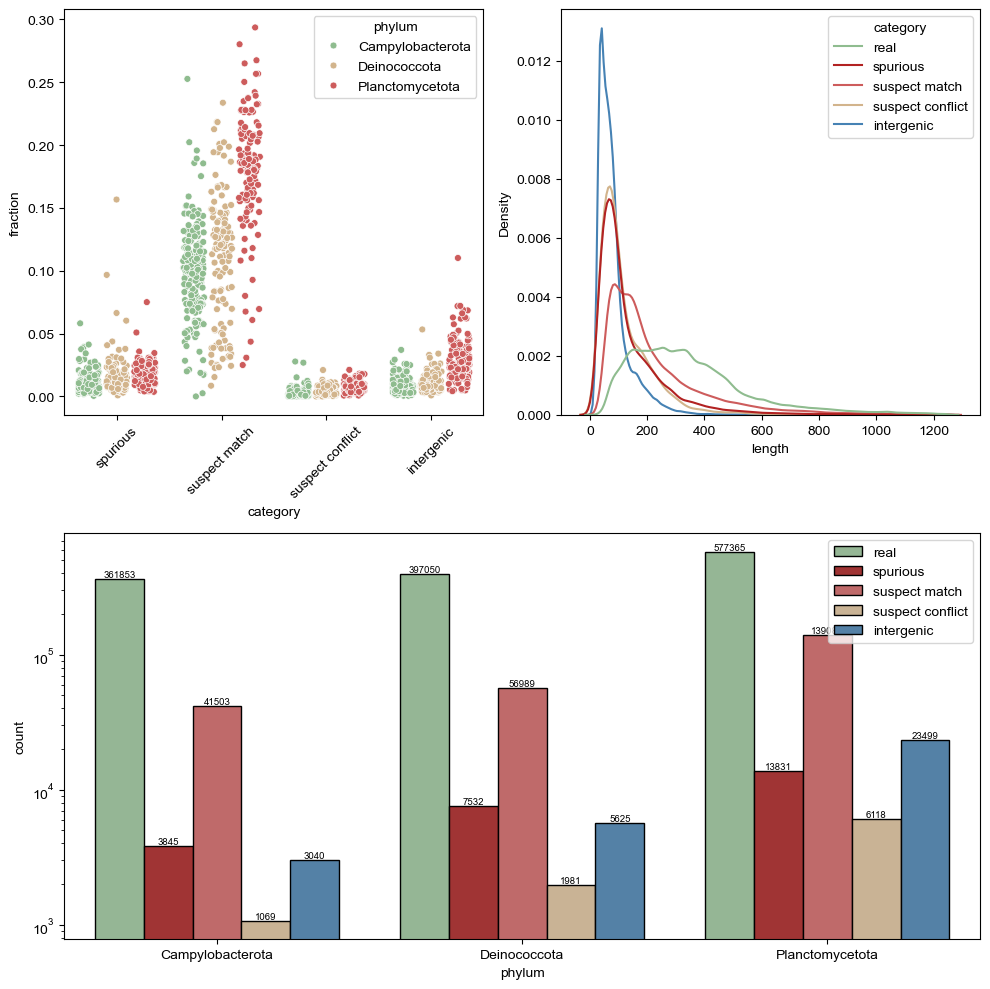

In [159]:
def figure_2(genome_metadata_df:pd.DataFrame, ref_df:pd.DataFrame, path:str='../figures/errors-figure_2.png'):

    fig = plt.figure(figsize=(10, 10), layout='tight')
    grid = GridSpec(nrows=2, ncols=2, figure=fig)
    ax_a, ax_b, ax_c = fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, :])

    ax_a_df = ref_df[['genome_id', 'spurious', 'suspect_match', 'suspect_conflict', 'intergenic']].copy()
    ax_a_df = ax_a_df.rename(columns={'suspect_match':'suspect match', 'suspect_conflict':'suspect conflict'})
    ax_a_df['phylum'] = ax_a_df.merge(genome_metadata_df[['phylum_name']], left_on='genome_id', right_index=True).phylum_name
    ax_a_df = ax_a_df.groupby('phylum').apply(lambda df : df.groupby('genome_id').mean(), include_groups=False).reset_index()
    ax_a_df = ax_a_df.melt(value_name='fraction', var_name='category', value_vars=['spurious', 'suspect match', 'suspect conflict', 'intergenic'], id_vars=['phylum'])
    colors = ['darkseagreen', 'tan', 'indianred']
    ax_a = sns.stripplot(data=ax_a_df, hue='phylum', y='fraction', x='category', ax=ax_a, palette=colors, edgecolor='white', linewidth=0.5, dodge=True, jitter=0.3)
    ax_a.set_xticks(np.arange(4), labels=ax_a.get_xticklabels(), rotation=45)

    ax_b_df = ref_df[['real', 'spurious', 'suspect_match', 'suspect_conflict', 'intergenic']].copy()
    ax_b_df = ax_b_df.rename(columns={'suspect_match':'suspect match', 'suspect_conflict':'suspect conflict'}) 
    ax_b_df['category'] = np.select([ax_b_df[col] for col in ax_b_df.columns], ax_b_df.columns, default='none')
    ax_b_df['length'] = get_lengths(ref_df, top_hit=False)
    ax_b_df = ax_b_df[ax_b_df.length < 1250]
    hue_order = ['real', 'spurious', 'suspect match', 'suspect conflict', 'intergenic']
    colors = ['darkseagreen', 'firebrick', 'indianred', 'tan', 'steelblue']
    sns.kdeplot(data=ax_b_df, hue='category', x='length', ax=ax_b, palette=colors, hue_order=hue_order, common_norm=False)


    ax_c_df = ref_df[['genome_id', 'real', 'spurious', 'suspect_match', 'suspect_conflict', 'intergenic']].copy()
    ax_c_df = ax_c_df.rename(columns={'suspect_match':'suspect match', 'suspect_conflict':'suspect conflict'})
    ax_c_df['phylum'] = ax_c_df.merge(genome_metadata_df[['phylum_name']], left_on='genome_id', right_index=True).phylum_name
    ax_c_df = ax_c_df.drop(columns='genome_id')
    ax_c_df = ax_c_df.groupby('phylum').sum().reset_index()
    hue_order = ['real', 'spurious', 'suspect match', 'suspect conflict', 'intergenic']
    colors = ['darkseagreen', 'firebrick', 'indianred', 'tan', 'steelblue']
    ax_c_df = ax_c_df.melt(id_vars='phylum', var_name='category', value_name='count', value_vars=['real', 'spurious', 'suspect match', 'suspect conflict', 'intergenic'])
    ax_c = sns.barplot(data=ax_c_df, x='phylum', hue='category', y='count', ax=ax_c, edgecolor='black', hue_order=hue_order, palette=colors)
    for p in ax_c.patches:
        ax_c.annotate(str(int(p.get_height())), xy=(p.get_x() + p.get_width() / 2,  p.get_height()), ha='center', va='bottom', fontsize='x-small')
    ax_c.set_yscale('log')
    ax_c.legend(loc='upper right')

figure_2(genome_metadata_df, ref_df)

In [ ]:
(ref_df[].sum(axis=1) != 1).sum()

np.int64(0)